# **Importing Libraries (Diabetes with Medical and Demographic Data) -SPARK**

In [ ]:
import os
import sys

In [ ]:
!pip install sparktorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 4.2 MB/s eta 0:00:00


In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=3157c040e4e9bf168d203c75585de9c8dbab9b897cf93a445868c79fbbd8fb9f
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.4.0/spark-3.4.0-bin-hadoop3.tgz
!tar xf spark-3.4.0-bin-hadoop3.tgz
!pip install -q findspark

In [ ]:
!java -version

openjdk version "11.0.19" 2023-04-18
OpenJDK Runtime Environment (build 11.0.19+7-post-Ubuntu-0ubuntu120.04.1)
OpenJDK 64-Bit Server VM (build 11.0.19+7-post-Ubuntu-0ubuntu120.04.1, mixed mode, sharing)


In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.0-bin-hadoop3"

In [ ]:
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version

update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java to provide /usr/bin/java (java) in manual mode
openjdk version "1.8.0_362"
OpenJDK Runtime Environment (build 1.8.0_362-8u372-ga~us1-0ubuntu1~20.04-b09)
OpenJDK 64-Bit Server VM (build 25.362-b09, mixed mode)


In [ ]:
!java -version

openjdk version "1.8.0_362"
OpenJDK Runtime Environment (build 1.8.0_362-8u372-ga~us1-0ubuntu1~20.04-b09)
OpenJDK 64-Bit Server VM (build 25.362-b09, mixed mode)


In [ ]:
import findspark
findspark.init()

In [ ]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession

In [ ]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from pyspark.sql import SparkSession
from pyspark.ml import feature
from pyspark.ml import regression
from pyspark.sql import functions as fn
from pyspark.sql.functions import countDistinct
from pyspark.sql import Row
from pyspark import sql
import seaborn as sns
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml import clustering
from pyspark.ml import classification
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import seaborn as sns
import decimal
from pyspark.sql.types import StructType
from pyspark.sql.types import *
from pyspark.ml.feature import StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import roc_curve, auc
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.util import MLUtils
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col, when
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
dataset = spark.read.csv("/content/diabetes_prediction_dataset.csv",header=True)

In [ ]:
dataset.show()

+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+
|gender| age|hypertension|heart_disease|smoking_history|  bmi|HbA1c_level|blood_glucose_level|diabetes|
+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+
|Female|80.0|           0|            1|          never|25.19|        6.6|                140|       0|
|Female|54.0|           0|            0|        No Info|27.32|        6.6|                 80|       0|
|  Male|28.0|           0|            0|          never|27.32|        5.7|                158|       0|
|Female|36.0|           0|            0|        current|23.45|        5.0|                155|       0|
|  Male|76.0|           1|            1|        current|20.14|        4.8|                155|       0|
|Female|20.0|           0|            0|          never|27.32|        6.6|                 85|       0|
|Female|44.0|           0|            0|          never|19.31|  

In [ ]:
dataset = dataset.withColumn('gender', when(dataset.gender.contains('Female'), 0)
                                     .when(dataset.gender.contains('Male'), 1)
                                     .otherwise(None))

# Convert 'gender' column to numeric
dataset = dataset.withColumn('gender', dataset.gender.cast('double'))

# Replace null values with random choice between 0 and 1
dataset = dataset.withColumn('gender', when(dataset.gender.isNull(),
                                           np.random.choice([0, 1]))
                                       .otherwise(dataset.gender))

In [ ]:
dataset = dataset.drop('smoking_history')

In [ ]:
dataset = dataset.withColumn("gender", when(col("gender") == "Male", 1).otherwise(0))

In [ ]:
dataset.show()

+------+----+------------+-------------+-----+-----------+-------------------+--------+
|gender| age|hypertension|heart_disease|  bmi|HbA1c_level|blood_glucose_level|diabetes|
+------+----+------------+-------------+-----+-----------+-------------------+--------+
|   0.0|80.0|           0|            1|25.19|        6.6|                140|       0|
|   0.0|54.0|           0|            0|27.32|        6.6|                 80|       0|
|   1.0|28.0|           0|            0|27.32|        5.7|                158|       0|
|   0.0|36.0|           0|            0|23.45|        5.0|                155|       0|
|   1.0|76.0|           1|            1|20.14|        4.8|                155|       0|
|   0.0|20.0|           0|            0|27.32|        6.6|                 85|       0|
|   0.0|44.0|           0|            0|19.31|        6.5|                200|       1|
|   0.0|79.0|           0|            0|23.86|        5.7|                 85|       0|
|   1.0|42.0|           0|      

In [ ]:
for col in dataset.columns:
    dataset = dataset.withColumn(col,dataset[col].cast('double'))

In [ ]:
inputCols = ["gender", "age", "hypertension", "heart_disease", "bmi", "HbA1c_level", "blood_glucose_level"]

In [ ]:
vectorAssembler = VectorAssembler(inputCols=inputCols, outputCol='features')
dataset_vector = vectorAssembler.transform(dataset)
dataset_vector.show(5)

+------+----+------------+-------------+-----+-----------+-------------------+--------+--------------------+
|gender| age|hypertension|heart_disease|  bmi|HbA1c_level|blood_glucose_level|diabetes|            features|
+------+----+------------+-------------+-----+-----------+-------------------+--------+--------------------+
|   0.0|80.0|         0.0|          1.0|25.19|        6.6|              140.0|     0.0|[0.0,80.0,0.0,1.0...|
|   0.0|54.0|         0.0|          0.0|27.32|        6.6|               80.0|     0.0|[0.0,54.0,0.0,0.0...|
|   1.0|28.0|         0.0|          0.0|27.32|        5.7|              158.0|     0.0|[1.0,28.0,0.0,0.0...|
|   0.0|36.0|         0.0|          0.0|23.45|        5.0|              155.0|     0.0|[0.0,36.0,0.0,0.0...|
|   1.0|76.0|         1.0|          1.0|20.14|        4.8|              155.0|     0.0|[1.0,76.0,1.0,1.0...|
+------+----+------------+-------------+-----+-----------+-------------------+--------+--------------------+
only showing top 5 

In [ ]:
dataset_vector.select("features","diabetes").show(5)

+--------------------+--------+
|            features|diabetes|
+--------------------+--------+
|[0.0,80.0,0.0,1.0...|     0.0|
|[0.0,54.0,0.0,0.0...|     0.0|
|[1.0,28.0,0.0,0.0...|     0.0|
|[0.0,36.0,0.0,0.0...|     0.0|
|[1.0,76.0,1.0,1.0...|     0.0|
+--------------------+--------+
only showing top 5 rows



In [ ]:
train, test = dataset_vector.randomSplit([0.8, 0.2], seed=0)

In [ ]:
train.show(4)

+------+----+------------+-------------+-----+-----------+-------------------+--------+--------------------+
|gender| age|hypertension|heart_disease|  bmi|HbA1c_level|blood_glucose_level|diabetes|            features|
+------+----+------------+-------------+-----+-----------+-------------------+--------+--------------------+
|   0.0|0.08|         0.0|          0.0|11.88|        5.7|               80.0|     0.0|[0.0,0.08,0.0,0.0...|
|   0.0|0.08|         0.0|          0.0|12.22|        3.5|              130.0|     0.0|[0.0,0.08,0.0,0.0...|
|   0.0|0.08|         0.0|          0.0| 12.5|        4.5|              155.0|     0.0|[0.0,0.08,0.0,0.0...|
|   0.0|0.08|         0.0|          0.0|12.74|        3.5|              140.0|     0.0|[0.0,0.08,0.0,0.0...|
+------+----+------------+-------------+-----+-----------+-------------------+--------+--------------------+
only showing top 4 rows



In [ ]:
print(train.count())
print(test.count())

79829
20171


In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [ ]:
layers = [7,5,5,2]

In [ ]:
classifier = MultilayerPerceptronClassifier(labelCol='diabetes',
                                            featuresCol='features',
                                            maxIter=25,
                                            layers=layers,
                                            seed=0)

In [ ]:
mlp_model = classifier.fit(train)

In [ ]:
pred_df = mlp_model.transform(test)

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol = 'diabetes', predictionCol = 'prediction', metricName = 'accuracy')
mlpacc = evaluator.evaluate(pred_df)
mlpacc

0.9139358484953646

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol = 'diabetes', predictionCol = 'prediction', metricName = 'precisionByLabel')
mlpacc = evaluator.evaluate(pred_df)
mlpacc

0.9139358484953646

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol = 'diabetes', predictionCol = 'prediction', metricName = 'recallByLabel')
mlpacc = evaluator.evaluate(pred_df)
mlpacc

1.0

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol = 'diabetes', predictionCol = 'prediction', metricName = 'f1')
mlpacc = evaluator.evaluate(pred_df)
mlpacc

0.8728388005497615

In [ ]:
pred_df.show(4)

+------+----+------------+-------------+-----+-----------+-------------------+--------+--------------------+--------------------+--------------------+----------+
|gender| age|hypertension|heart_disease|  bmi|HbA1c_level|blood_glucose_level|diabetes|            features|       rawPrediction|         probability|prediction|
+------+----+------------+-------------+-----+-----------+-------------------+--------+--------------------+--------------------+--------------------+----------+
|   0.0|0.16|         0.0|          0.0| 12.7|        4.5|               90.0|     0.0|[0.0,0.16,0.0,0.0...|[0.44955254930175...|[0.91514980937918...|       0.0|
|   0.0|0.16|         0.0|          0.0| 12.7|        6.1|              145.0|     0.0|[0.0,0.16,0.0,0.0...|[0.44955254930175...|[0.91514980937918...|       0.0|
|   0.0|0.16|         0.0|          0.0|13.78|        5.0|              200.0|     0.0|[0.0,0.16,0.0,0.0...|[0.44955254930175...|[0.91514980937918...|       0.0|
|   0.0|0.16|         0.0|  

In [ ]:
pred_df.columns

['gender',
 'age',
 'hypertension',
 'heart_disease',
 'bmi',
 'HbA1c_level',
 'blood_glucose_level',
 'diabetes',
 'features',
 'rawPrediction',
 'probability',
 'prediction']

In [ ]:
pred_df = pred_df.withColumn('diabetes',pred_df['diabetes'].cast('double'))
pred_df = pred_df.withColumn('prediction',pred_df['prediction'].cast('double'))

In [ ]:
pred_df = pred_df.select("diabetes", "prediction")

In [ ]:
predictions_pd = pred_df.toPandas()

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
classes = ['No Diabetes', 'Diabetes']
clr = classification_report(predictions_pd['diabetes'], predictions_pd['prediction'], target_names=classes, zero_division=1)
print("Classification Report:\n-----------------------------\n", clr)

Classification Report:
-----------------------------
               precision    recall  f1-score   support

 No Diabetes       0.91      1.00      0.96     18435
    Diabetes       1.00      0.00      0.00      1736

    accuracy                           0.91     20171
   macro avg       0.96      0.50      0.48     20171
weighted avg       0.92      0.91      0.87     20171



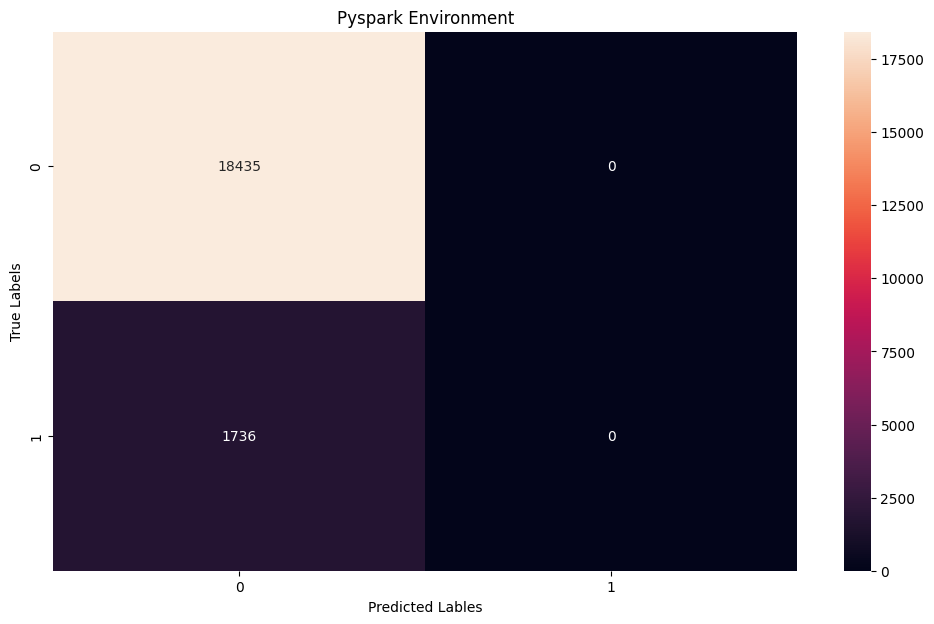

In [ ]:
plt.figure(figsize = (12,7))
ax = plt.subplot()
cf_matrix = confusion_matrix(predictions_pd['diabetes'], predictions_pd['prediction'])
sns.heatmap(cf_matrix , annot=True, fmt="g", ax = ax)
plt.title('Pyspark Environment')
plt.xlabel("Predicted Lables")
plt.ylabel("True Labels")
plt.show()